## Imports and List Amino Acid Codes

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
import numpy as np
from Bio.PDB import *
import os
import warnings
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

amino3CodesStr = 'alaargasnaspcysgluglnglyhisileleulysmetpheproserthrtrptyrval'
amino3Codes = [amino3CodesStr[x:x+3].upper() for x in range(0, len(amino3CodesStr), 3)]
amino3Codes = list(sorted(amino3Codes))
print(amino3Codes, len(amino3Codes)) 

['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'] 20


## Antigen Antibody Combination Frequency
### Antigen and Antibody


Out of all antigen residues interacting with antibody, add up the number of antigen residue codes to a dictionary, divide by number of times amino acid appears in antigen as a whole

In [2]:
# Initialize two empty antigen interaction list, one for interacting region one for total
AgSurfaceList, AbSurfaceList = {}, {}
AgTotalList, AbTotalList = {}, {}
ranges = [[27, 36], [48, 60], [91, 104]]
for i in range(len(amino3Codes)):
    combinationName = amino3Codes[i]
    AgSurfaceList[combinationName] = 0
    AgTotalList[combinationName] = 0
    AbSurfaceList[combinationName] = 0
    AbTotalList[combinationName] = 0

parser = PDBParser()
for filename in os.listdir("cleanAbAgData"):
    InteractingAgList = []
    data = parser.get_structure(filename[:-4], "cleanAbAgData/"+filename)
    chains = list(list(data.get_models())[0].get_chains())
    chainL, chainH = [], []
    agChains, AbCDR = [], []
    for x in chains: # for chain in chains
        if x.id == "L":
            chainL = list(x.get_residues())
        elif x.id == "H":
            chainH = list(x.get_residues())
        else:
            agChains += list(x.get_residues())
    chainsLH = [chainL, chainH]
    for chainX in chainsLH:
        for r in ranges:
            fst, snd = r[0], r[1]
            AbCDR += chainX[fst-1: snd]
    AbCDR = [x for x in AbCDR if x.get_resname() in amino3Codes]
    singleChainLH = chainL + chainH
    singleChainLH = [x for x in singleChainLH if x.get_resname() in amino3Codes]
    # Create atom list of Ab residues for searching later 
    AbAtomList = [list(x.get_atoms()) for x in singleChainLH]
    AbAtomList = list(chain.from_iterable(AbAtomList))
    AgAtomList = [list(x.get_atoms()) for x in agChains if x.get_resname() in amino3Codes]
    AgAtomList = list(chain.from_iterable(AgAtomList))
    NBSearch = NeighborSearch(AbAtomList)
    NBSearch2 = NeighborSearch(AgAtomList)

    ### Gather Ag residues interacting with Ab 
    for x in chains:
        currRes = list(x.get_residues())
        if x.id != "L" and x.id != "H":
            for res in currRes:
                AgTotalList[res.get_resname()] += 1
                for atm in list(res.get_atoms()):
                    centerPos = atm.coord
                    ## Add to name in antigen total dictionary
                    if len(NBSearch.search(centerPos, 5, 'R')) > 0:
                        ## Add to name in dictionary
                        AgSurfaceList[res.get_resname()] += 1
                        break # break after a single atom from the residue interacts with Ab 

    for res in AbCDR:
        AbSurfaceList[res.get_resname()] += 1
    for res in singleChainLH:
        AbTotalList[res.get_resname()] += 1

c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5079
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5080
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5081
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5082
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5083
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5084
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 

In [4]:
CombinedSurfaceList, CombinedTotalList = dict(Counter(AgSurfaceList) + Counter(AbSurfaceList)), dict(Counter(AgTotalList) + Counter(AbTotalList))
AgRatios = {k: AgSurfaceList[k] / AgTotalList.get(k, 0) for k in AgSurfaceList.keys()}
AbRatios = {k: AbSurfaceList[k] / AbTotalList.get(k, 0) for k in AbSurfaceList.keys()}
ComRatios = {k: CombinedSurfaceList[k] / CombinedTotalList.get(k, 0) for k in CombinedSurfaceList.keys()}
catBarData = pd.DataFrame([AgRatios, AbRatios, ComRatios], index=['Antigen', 'Antibody', 'Combined']).T
catBarData.index.name = 'Amino Acid Code'
catBarData.to_csv("usefulOutputs/Relative_Frequency_Interactive_Region_Bar_Values.csv")

Text(0.5, 1.0, 'Relative Frequency of Amino Acid Types in Ag/Ab Protein Interactive Regions')

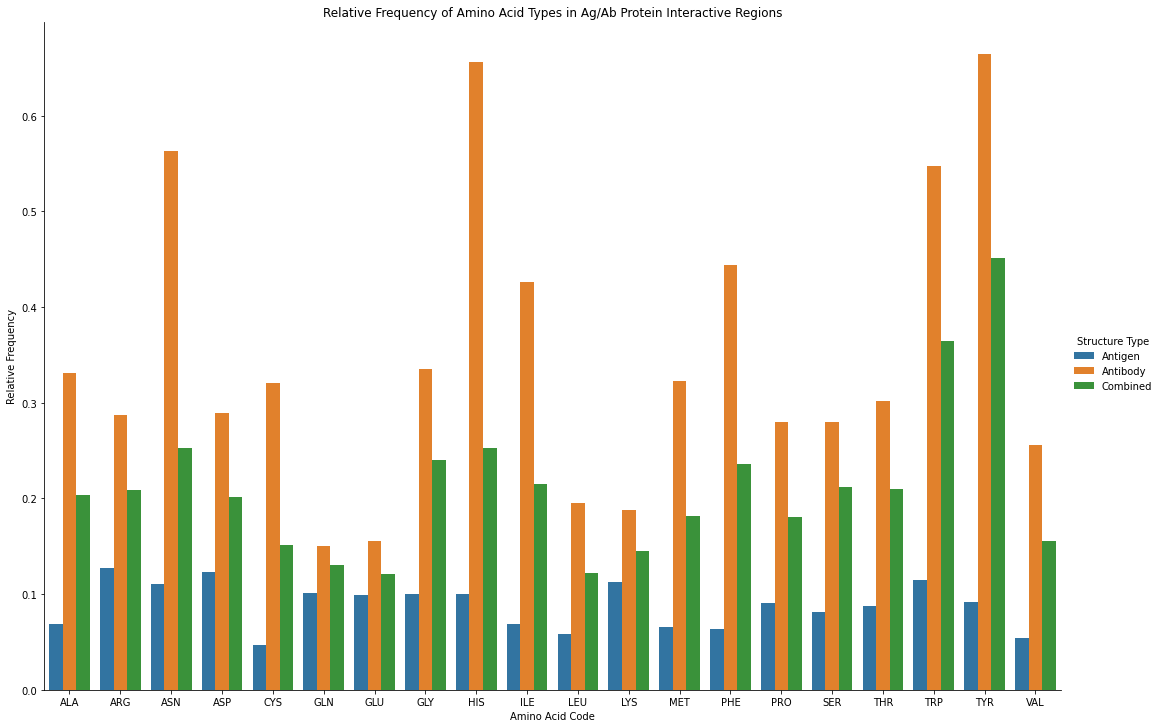

In [5]:
catBarData = catBarData.reset_index()
catBarData = pd.melt(catBarData, id_vars=['Amino Acid Code'], var_name='Structure Type', value_name='Relative Frequency')
fig = sns.catplot(x='Amino Acid Code', y='Relative Frequency', hue='Structure Type', data=catBarData, kind='bar', height=10, aspect=1.5)
plt.title("Relative Frequency of Amino Acid Types in Ag/Ab Protein Interactive Regions")

### 20x20 Interaction Adjusted Relative Frequency Heatmap

In [6]:
# Initialize two empty amino acid {code: count} interaction list
# These will be the total for antibody and antigen respectively
# At the end, can divide columns and rows by both and then make a heatmap

AgHalfList, AbHalfList = {}, {}
BothInterList = {}
freqChart = np.empty((20, 20))
freqChart.fill(np.nan)

for i in range(len(amino3Codes)):
    for j in range(len(amino3Codes)):
        combinationName = amino3Codes[i] + " " + amino3Codes[j]
        BothInterList[combinationName] = 0

ranges = [[27, 36], [48, 60], [91, 104]]
for i in range(len(amino3Codes)):
    combinationName = amino3Codes[i]
    AgHalfList[combinationName] = 0
    AbHalfList[combinationName] = 0

parser = PDBParser()
for filename in os.listdir("cleanAbAgData"):
    InteractingAgList = []
    data = parser.get_structure(filename[:-4], "cleanAbAgData/"+filename)
    chains = list(list(data.get_models())[0].get_chains())
    chainL, chainH = [], []
    agChains, AbCDR = [], []
    for x in chains: # for chain in chains
        if x.id == "L":
            chainL = list(x.get_residues())
        elif x.id == "H":
            chainH = list(x.get_residues())
        else:
            agChains += list(x.get_residues())
    chainsLH = [chainL, chainH]
    for chainX in chainsLH:
        for r in ranges:
            fst, snd = r[0], r[1]
            AbCDR += chainX[fst-1: snd]
    AbCDR = [x for x in AbCDR if x.get_resname() in amino3Codes]
    AgAtomList = [list(x.get_atoms()) for x in agChains if x.get_resname() in amino3Codes]
    AgAtomList = list(chain.from_iterable(AgAtomList))
    NBSearch2 = NeighborSearch(AgAtomList)

    for res in AbCDR:
        for atm in list(res.get_atoms()):
            centerPos = atm.coord
            located_ag = NBSearch2.search(centerPos, 5, 'R')
            located_ag = [x.get_resname() for x in located_ag]
            if len(located_ag) > 0:
                ## Add to name in dictionary
                for ag_res in located_ag:
                    BothInterList[res.get_resname() + " " + ag_res] += 1
                    AbHalfList[res.get_resname()] += 1
                    AgHalfList[ag_res] += 1
                break # break after a single atom from the residue interacts with Ab 

for AbRow, code1 in enumerate(amino3Codes):
    for AgCol, code2 in enumerate(amino3Codes):
        curr_name = code1 + " " + code2
        curr_val = BothInterList[curr_name] 
        if curr_val > 0:
            curr_val = curr_val / AbHalfList[code1] / AgHalfList[code2]
        freqChart[AbRow, AgCol] = curr_val

c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5079
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5080
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5081
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5082
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5083
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5084
  warnings.warn(
c:\Python310\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 

In [7]:
np.savetxt("usefulOutputs/External_Interaction_Frequency_AbAg_Heatmap.txt", freqChart)

0.0007683442182097579


Text(0.5, 1.0, 'Residue External Interaction Combination Relative Frequency of Ab/Ag Dataset')

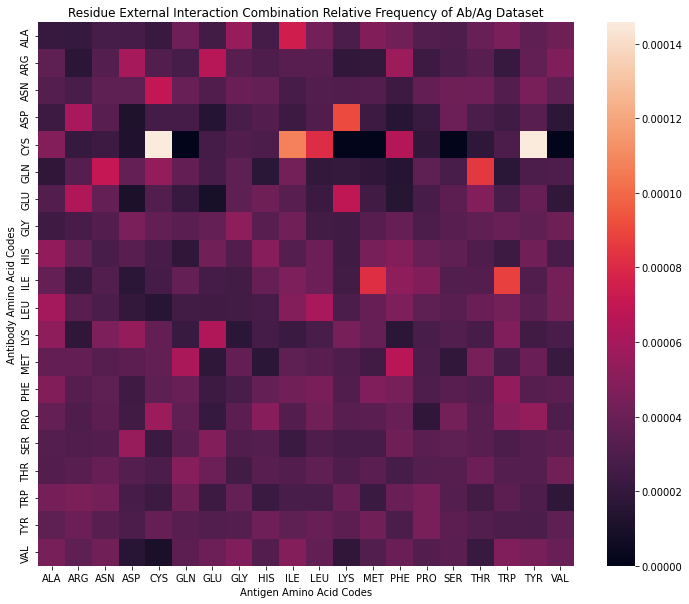

In [27]:
fig = plt.figure(figsize=(12, 10))
outlier = freqChart[4, 4]
print(outlier)
freqChart[4, 4] = freqChart[4, 18]
ax = sns.heatmap(freqChart, cmap=sns.color_palette("rocket", as_cmap=True))
ax.set_xticklabels(amino3Codes)
ax.set_yticklabels(amino3Codes)
ax.set_ylabel("Antibody Amino Acid Codes")
ax.set_xlabel("Antigen Amino Acid Codes")
plt.title("Residue External Interaction Combination Relative Frequency of Ab/Ag Dataset")